# Final Project

Big Data Platforms </br>Nic Carlson

In [1]:
# Date notebook was last run
import datetime
import pytz

datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")

'Mon, 15 March 2021 19:27:54'

## Setup environment, import data that was pulled via Spark and cleaned in Alteryx

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from itertools import compress 
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')

[nltk_data] Downloading package stopwords to C:\Users\carlson
[nltk_data]     nic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
## So I had to import it using pandas then convert it to a spark DF
%time dfPandas = pd.read_csv('tweets_all.csv',lineterminator='\r')

<string>:2: DtypeWarning: Columns (0,9,10,11,16) have mixed types.Specify dtype option on import or set low_memory=False.


Wall time: 50.1 s


In [138]:
# Protecting original df to avoid having to re-import
df = dfPandas

In [30]:
df.head(2)

,user_id,friends_count,user_location,user_name,user_screen_name,user_created_at,user_created_at_date,description,favourites_count,user_followers_count,...,tweet_lang,retweeted_count,retweet_created_at,retweet_created_at_date,retweet_lag_minutes,retweeted_status_followers_count,retweet_user_name,retweet_user_location,length_of_text,School
0,\n741067300866916352,2076.0,"San Francisco, CA",Nathan Mannas,ncMannas,2016-06-10 00:39:47,2016-06-10,"Food, the arts, sports and tech. A new account, a fresh start.",12343.0,1260,...,en,50,2017-06-22 17:41:07,2017-06-22,341.0,140549.0,History in Moments,NaN,85.0,Harvard
1,\n22101365,1136.0,"Houston, TX 77081, United Stat",MarVer,mlv1313,2009-02-27 03:21:06,2009-02-27,Travel junkie. Master's degree in social work. Nasty Woman & Fighter for human rights #Resistance #PSR. Flip the House Proud snowflake...Winter is coming 2018,5767.0,400,...,en,7,2017-06-22 22:38:28,2017-06-22,46.0,415880.0,Dave Weasel,"Los Angeles, California",132.0,Harvard


## A little additional data cleaning, EDA, and validation the data came in correctly (some already done in Alteryx)

#### Remove a few messy rows caused by CSV formatting issues

##### User counts (~25 records)

In [140]:
# Cleaning up ~25 dirty records
df = df[df.user_followers_count != 'Wed Dec 13 01:47:05 +0000 2017']
df = df[df.retweeted_count != "Jason O'Toole"]

#### Convert date and extract hour

In [131]:
# Converting tweet_created_at time

date_parser = pd.to_datetime
df['tweet_created_at'] = date_parser(df['tweet_created_at'])

C:\Users\carlson nic\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [132]:
# Extracting hour into new column

df['tweet_created_at_hour'] = df['tweet_created_at'].dt.hour

C:\Users\carlson nic\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Need to change NaN retweeted_counts to 0

In [141]:
print (df[pd.to_numeric(df['retweeted_count'], errors='coerce').isnull()])

              user_id  friends_count             user_location  \
5         \n441214858         1077.0  Eppur si muove-Keith Law   
7         \n441214858         1077.0  Eppur si muove-Keith Law   
17        \n223709253          419.0                slamcouver   
18        \n465545296          164.0                        NY   
23       \n3302153561         2805.0        Christiansburg, VA   
...               ...            ...                       ...   
5594062  \n2429718336         1469.0       West Palm Beach, FL   
5594065  \n1876704955          340.0               Latrobe, PA   
5594066   \n226721962          150.0                    Madrid   
5594072  \n1252806792         2870.0                 Worldwide   
5594073            \n            NaN                       NaN   

                   user_name user_screen_name      user_created_at  \
5            Jerome McCollom  LetHumanismRing  2011-12-19 21:26:06   
7            Jerome McCollom  LetHumanismRing  2011-12-19 21:26:06 

In [142]:
print('BEFORE:', df['retweeted_count'].isnull().values.any())

BEFORE: True


In [143]:
# fillna function
df['retweeted_count'].fillna(0, inplace=True)

print('AFTER:',df['retweeted_count'].isnull().values.any())

AFTER: False


In [148]:
df.astype({'retweeted_count': 'float'}).astype({'retweeted_count': 'int32'}).dtypes

user_id                              object
friends_count                       float64
user_location                        object
user_name                            object
user_screen_name                     object
user_created_at                      object
user_created_at_date                 object
description                          object
favourites_count                    float64
user_followers_count                 object
tweet_favorite_count                 object
tweet_id                             object
tweet_created_at                     object
tweet_created_at_date                object
text                                 object
tweet_lang                           object
retweeted_count                       int32
retweet_created_at                   object
retweet_created_at_date              object
retweet_lag_minutes                 float64
retweeted_status_followers_count    float64
retweet_user_name                    object
retweet_user_location           

#### Create weighted value for tweets based on whether or not they were retweeted. 1 'point' if it's just a tweet. '2 points for retweets'

In [152]:
df['influencer_weight'] = np.where(df['retweeted_count'] == 0, 1, 2)

In [153]:
df['influencer_weight']

0          2
1          2
2          2
3          2
4          2
          ..
5594069    2
5594070    2
5594071    2
5594072    1
5594073    1
Name: influencer_weight, Length: 5594042, dtype: int32

#### Cleanup additional NAs and then change data types

In [157]:
df.astype({'retweeted_count': 'float', 'influencer_weight': 'float'}).astype({'retweeted_count': 'int32', 'influencer_weight': 'int32'}).dtypes

user_id                              object
friends_count                       float64
user_location                        object
user_name                            object
user_screen_name                     object
user_created_at                      object
user_created_at_date                 object
description                          object
favourites_count                    float64
user_followers_count                 object
tweet_favorite_count                 object
tweet_id                             object
tweet_created_at                     object
tweet_created_at_date                object
text                                 object
tweet_lang                           object
retweeted_count                       int32
retweet_created_at                   object
retweet_created_at_date              object
retweet_lag_minutes                 float64
retweeted_status_followers_count    float64
retweet_user_name                    object
retweet_user_location           

<AxesSubplot:>

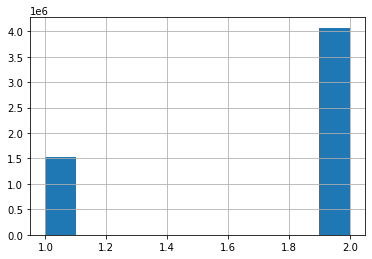

In [161]:
df['influencer_weight'].hist()

#### Validate number of records

In [162]:
# 5.6M total records now, down from 
df["School"].count()

5594041

In [13]:
# This represents just over 1% of total records
5594073/500000000

0.011188146

<AxesSubplot:>

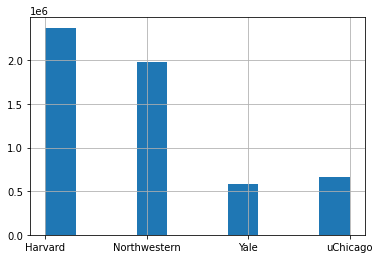

In [163]:
# All schools have at least 500k records
df["School"].hist()

## Identify the most prolific / influential Twitterers:

In [81]:
# A simple count of tweets by user screen name overall
df.value_counts('user_screen_name')[:10]

user_screen_name
NSUDemonsFans      2507
kinibottommintd    1689
mba_buddy          1032
Sports_Journal     1020
Andrew_weather      934
cbhhughes21         860
grhluna24           836
BourbonStreet2      758
amcneer             739
SportsKT            732
dtype: int64

### 1) uChicago by message volume and sum of retweets and weighted (RetweedTweet = 1, NonRetweetedTweet = .5)

In [84]:
# uChicago top twitterer by volume
dfSchoolGrouping = df.groupby(['School', 'user_screen_name'], as_index=False)['user_id'].count()
uChicagoTweeters = dfSchoolGrouping[dfSchoolGrouping['School'].str.contains("uChicago")].sort_values(by='user_id', ascending=False)
uChicagoTweeters.head()

,School,user_screen_name,user_id
2604126,uChicago,chicagoboothrev,639
2728565,uChicago,uchicagogsu,457
2430328,uChicago,AlexBender7,392
2704523,uChicago,ruthpaget,359
2682607,uChicago,n8taki,291


In [70]:
# uChicago top twitterer by total sum of retweets
dfSchoolGrouping = df.groupby(['School', 'user_screen_name'], as_index=False)['retweeted_count'].sum()
uChicagoRetweeters = dfSchoolGrouping[dfSchoolGrouping['School'].str.contains("uChicago")].sort_values(by='retweeted_count', ascending=False)
uChicagoRetweeters.head()

,School,user_screen_name,retweeted_count
2456126,uChicago,CyanFour,25502.0
2737412,uChicago,yiizo,24480.0
2722199,uChicago,the_gwalla,24437.0
2497639,uChicago,Katja_Thieme,24183.0
2570396,uChicago,YaniraaMcNeil,24064.0


In [164]:
# uChicago top twitterer by total sum of retweets
dfSchoolGrouping = df.groupby(['School', 'user_screen_name'], as_index=False)['influencer_weight'].sum()
uChicagoRetweeters = dfSchoolGrouping[dfSchoolGrouping['School'].str.contains("uChicago")].sort_values(by='influencer_weight', ascending=False)
uChicagoRetweeters.head()

,School,user_screen_name,influencer_weight
3078411,uChicago,UChicagoMedJobs,2153
3131215,uChicago,chicagoboothrev,1424
2924500,uChicago,ChicagoMaroons,1234
3290571,uChicago,uchicagogsu,1128
2896041,uChicago,AlexBender7,785


### 1) Harvard by message volume and sum of retweets

In [85]:
# harvard top twitterer by volume
dfSchoolGrouping = df.groupby(['School', 'user_screen_name'], as_index=False)['user_id'].count()
harvardTweeters = dfSchoolGrouping[dfSchoolGrouping['School'].str.contains("Harvard")].sort_values(by='user_id', ascending=False)
harvardTweeters.head()

,School,user_screen_name,user_id
1109318,Harvard,mba_buddy,810
913321,Harvard,grhluna24,803
94135,Harvard,BourbonStreet2,758
203356,Harvard,FrasierHarry,550
607486,Harvard,WaterPolo0714,206


In [69]:
# Harvard top twitterer by total sum of retweets
dfSchoolGrouping = df.groupby(['School', 'user_screen_name'], as_index=False)['retweeted_count'].sum()
harvardRetweeters = dfSchoolGrouping[dfSchoolGrouping['School'].str.contains("Harvard")].sort_values(by='retweeted_count', ascending=False)
harvardRetweeters.head()

,School,user_screen_name,retweeted_count
949554,Harvard,idekchia,688240.0
657733,Harvard,_nnajib,632280.0
125007,Harvard,Christian_B56,603869.0
1181752,Harvard,olanaaaaa,589366.0
493518,Harvard,Rosenchild,544043.0


In [165]:
# Harvard top twitterer by total sum of retweets
dfSchoolGrouping = df.groupby(['School', 'user_screen_name'], as_index=False)['influencer_weight'].sum()
harvardRetweeters = dfSchoolGrouping[dfSchoolGrouping['School'].str.contains("Harvard")].sort_values(by='influencer_weight', ascending=False)
harvardRetweeters.head()

,School,user_screen_name,influencer_weight
267118,Harvard,HarvardStudyBot,2272
1185081,Harvard,kryssew,1915
892016,Harvard,cecesoojung,1849
1253858,Harvard,mba_buddy,1620
1037635,Harvard,grhluna24,1606


### 1) Northwestern by message volume and sum of retweets

In [87]:
# harvard top twitterer by volume
dfSchoolGrouping = df.groupby(['School', 'user_screen_name'], as_index=False)['user_id'].count()
nwTweeters = dfSchoolGrouping[dfSchoolGrouping['School'].str.contains("Northwestern")].sort_values(by='user_id', ascending=False)
nwTweeters.head()

,School,user_screen_name,user_id
1647168,Northwestern,NSUDemonsFans,2500
1710548,Northwestern,Sports_Journal,1019
1444070,Northwestern,Andrew_weather,933
1814086,Northwestern,cbhhughes21,853
1710440,Northwestern,SportsKT,732


In [88]:
# Harvard top twitterer by total sum of retweets
dfSchoolGrouping = df.groupby(['School', 'user_screen_name'], as_index=False)['retweeted_count'].sum()
nwRetweeters = dfSchoolGrouping[dfSchoolGrouping['School'].str.contains("Northwestern")].sort_values(by='retweeted_count', ascending=False)
nwRetweeters.head()

,School,user_screen_name,retweeted_count
2051530,Northwestern,wmzafravelasco,89722.0
1987923,Northwestern,raybae689,74209.0
1890662,Northwestern,jared_secret,44027.0
1570629,Northwestern,JacobG88,39369.0
1809118,Northwestern,bz80qrlXkWpoBcT,38263.0


In [166]:
# Harvard top twitterer by total sum of retweets
dfSchoolGrouping = df.groupby(['School', 'user_screen_name'], as_index=False)['influencer_weight'].sum()
nwRetweeters = dfSchoolGrouping[dfSchoolGrouping['School'].str.contains("Northwestern")].sort_values(by='influencer_weight', ascending=False)
nwRetweeters.head()

,School,user_screen_name,influencer_weight
1630328,Northwestern,AmericaAlerts,6313
1911421,Northwestern,NSUDemonsFans,5620
2052352,Northwestern,WXHAZARDSKS,4643
2337240,Northwestern,newstarsbot,3642
2232070,Northwestern,insidenu,3285


### 1) Yale by message volume and sum of retweets

In [86]:
# Yale top twitterer by volume
dfSchoolGrouping = df.groupby(['School', 'user_screen_name'], as_index=False)['user_id'].count()
yaleTweeters = dfSchoolGrouping[dfSchoolGrouping['School'].str.contains("Yale")].sort_values(by='user_id', ascending=False)
yaleTweeters.head()

,School,user_screen_name,user_id
2332048,Yale,kinibottommintd,1661
2308156,Yale,honischgalerie,691
2281023,Yale,dantereno10,230
2415491,Yale,wendchain,224
2358569,Yale,n8taki,223


In [71]:
# Harvard top twitterer by total sum of retweets
dfSchoolGrouping = df.groupby(['School', 'user_screen_name'], as_index=False)['retweeted_count'].sum()
yaleRetweeters = dfSchoolGrouping[dfSchoolGrouping['School'].str.contains("Yale")].sort_values(by='retweeted_count', ascending=False)
yaleRetweeters.head()

,School,user_screen_name,retweeted_count
2349962,Yale,meghanaaa,219025.0
2377018,Yale,raybae689,186120.0
2310196,Yale,iambrittania,180870.0
2110554,Yale,EXFURIBISTA,120301.0
2329043,Yale,kaylaiko_,114448.0


In [167]:
# Harvard top twitterer by total sum of retweets
dfSchoolGrouping = df.groupby(['School', 'user_screen_name'], as_index=False)['influencer_weight'].sum()
yaleRetweeters = dfSchoolGrouping[dfSchoolGrouping['School'].str.contains("Yale")].sort_values(by='influencer_weight', ascending=False)
yaleRetweeters.head()

,School,user_screen_name,influencer_weight
2782143,Yale,kinibottommintd,6994
2755284,Yale,honischgalerie,1801
2738319,Yale,esquireattire,1349
2532422,Yale,Finance_graduat,562
2724090,Yale,dantereno10,460


## How much are they tweeting about the Universities vs. other topics?

In [147]:
from io import StringIO

In [148]:
l = ['uchicago.edu','uc','uofc','graham','uchicago', 'university of chicago', 'uchicagolaw', 'Phil the Phoenix', 'maroons', 'chicago maroons']
InfluencersuChicago = pd.read_csv('InfluencersuChicago.csv',lineterminator='\n')
InfluencersuChicago['text'] = InfluencersuChicago['text'].str.lower()
l = [x.lower() for x in l]
InfluencersuChicago['university_tweet'] = InfluencersuChicago['text'].apply(lambda x: ','.join([i for i in l if i in x]))
print("Total influencer tweets: {}".format(InfluencersuChicago['user_id'].count()))
print("About the univeersity: {}".format(round((InfluencersuChicago['university_tweet'].values != '').sum() / (InfluencersuChicago['university_tweet'].count()),2)))

Total influencer tweets: 2479
About the univeersity: 0.11


In [149]:
l = ['Northwestern', 'Northwestern University']
InfluencersNW = pd.read_csv('InfluencersNW.csv',lineterminator='\n')
InfluencersNW['text'] = InfluencersNW['text'].str.lower()
l = [x.lower() for x in l]
InfluencersNW['university_tweet'] = InfluencersNW['text'].apply(lambda x: ','.join([i for i in l if i in x]))
print("Total influencer tweets: {}".format(InfluencersNW['user_id'].count()))
print("About the univeersity: {}".format(round((InfluencersNW['university_tweet'].values != '').sum() / (InfluencersNW['university_tweet'].count()),2)))

Total influencer tweets: 11475
About the univeersity: 0.01


In [150]:
l = ['Harvard', 'Harvard University']
InfluencersHarvard = pd.read_csv('InfluencersHarvard.csv',lineterminator='\n')
InfluencersHarvard['text'] = InfluencersHarvard['text'].str.lower()
l = [x.lower() for x in l]
InfluencersHarvard['university_tweet'] = InfluencersHarvard['text'].apply(lambda x: ','.join([i for i in l if i in x]))
print("Total influencer tweets: {}".format(InfluencersHarvard['user_id'].count()))
print("About the univeersity: {}".format((InfluencersHarvard['university_tweet'].values != '').sum() / (InfluencersHarvard['university_tweet'].count())))

Total influencer tweets: 13536
About the univeersity: 0.005097517730496454


In [151]:
l = ['Yale', 'Yale University']
InfluencersYale = pd.read_csv('InfluencersYale.csv',lineterminator='\n')
InfluencersYale['text'] = InfluencersYale['text'].str.lower()
l = [x.lower() for x in l]
InfluencersYale['university_tweet'] = InfluencersYale['text'].apply(lambda x: ','.join([i for i in l if i in x]))
print("Total influencer tweets: {}".format(InfluencersYale['user_id'].count()))
print("About the univeersity: {}".format(round((InfluencersYale['university_tweet'].values != '').sum() / (InfluencersYale['university_tweet'].count()),2)))

Total influencer tweets: 6325
About the univeersity: 0.01


## Where are the Twitterers located? 

### For UChicago

In [90]:
# uCHicago tweet locations
dfSchoolGrouping = df.groupby(['School', 'user_location'], as_index=False)['user_id'].count()
uChicagoLocations = dfSchoolGrouping[dfSchoolGrouping['School'].str.contains("uChicago")].sort_values(by='user_id', ascending=False)
uChicagoLocations.head()

,School,user_location,user_id
576506,uChicago,"Chicago, IL",16175
622191,uChicago,United States,6665
576105,uChicago,Chicago,5607
574514,uChicago,"California, USA",3641
595955,uChicago,"Los Angeles, CA",3635


In [89]:
# Northwester tweet locations
dfSchoolGrouping = df.groupby(['School', 'user_location'], as_index=False)['user_id'].count()
nwLocations = dfSchoolGrouping[dfSchoolGrouping['School'].str.contains("Northwestern")].sort_values(by='user_id', ascending=False)
nwLocations.head()

,School,user_location,user_id
352788,Northwestern,"Chicago, IL",19289
440654,Northwestern,United States,14830
365332,Northwestern,"Evanston, IL",6689
352330,Northwestern,Chicago,6651
376636,Northwestern,"Houston, TX",5235


In [91]:
# harvard tweet locations
dfSchoolGrouping = df.groupby(['School', 'user_location'], as_index=False)['user_id'].count()
harvardLocations = dfSchoolGrouping[dfSchoolGrouping['School'].str.contains("Harvard")].sort_values(by='user_id', ascending=False)
harvardLocations.head()

,School,user_location,user_id
213623,Harvard,United States,33403
101225,Harvard,India,15633
47319,Harvard,"California, USA",12077
211607,Harvard,USA,11893
200375,Harvard,"Texas, USA",10183


In [92]:
# yale tweet locations
dfSchoolGrouping = df.groupby(['School', 'user_location'], as_index=False)['user_id'].count()
yaleLocations = dfSchoolGrouping[dfSchoolGrouping['School'].str.contains("Yale")].sort_values(by='user_id', ascending=False)
yaleLocations.head()

,School,user_location,user_id
539786,Yale,United States,10668
539137,Yale,USA,4626
487445,Yale,"California, USA",3552
535399,Yale,"Texas, USA",3187
504335,Yale,India,2933


### Do you see any relationship between university locations and Twitterers’ locations?

In [ ]:
# Yes

### Visualize the relationships

In [94]:
# Visualized stacked bar of pct of universities tweets by twitterer location in PowerPoint

## Where are these RETwitterers located? #TODO Potentially add this info to presentation 

### For UChicago

In [95]:
# uCHicago tweet locations
dfSchoolGrouping = df.groupby(['School', 'retweet_user_location'], as_index=False)['user_id'].count()
uChicagoLocations = dfSchoolGrouping[dfSchoolGrouping['School'].str.contains("uChicago")].sort_values(by='user_id', ascending=False)
uChicagoLocations.head()

,School,retweet_user_location,user_id
47681,uChicago,"Chicago, IL",34428
48196,uChicago,DC/NYCNative/❤️ in #Ferguson,10883
52683,uChicago,Philippines,9642
47586,uChicago,Chicago,9211
56860,uChicago,✶ ✶ ✶ ✶,8559


In [96]:
# Northwester tweet locations
dfSchoolGrouping = df.groupby(['School', 'retweet_user_location'], as_index=False)['user_id'].count()
nwLocations = dfSchoolGrouping[dfSchoolGrouping['School'].str.contains("Northwestern")].sort_values(by='user_id', ascending=False)
nwLocations.head()

,School,retweet_user_location,user_id
22791,Northwestern,"Chicago, IL",60515
29202,Northwestern,"Miami, FL",23728
24750,Northwestern,"Evanston, IL",19361
30337,Northwestern,"New York, NY",17842
35606,Northwestern,United States,15386


In [97]:
# harvard tweet locations
dfSchoolGrouping = df.groupby(['School', 'retweet_user_location'], as_index=False)['user_id'].count()
harvardLocations = dfSchoolGrouping[dfSchoolGrouping['School'].str.contains("Harvard")].sort_values(by='user_id', ascending=False)
harvardLocations.head()

,School,retweet_user_location,user_id
10259,Harvard,"Opelousas, LA",168604
10539,Harvard,"Palmira, Colombia",65878
5329,Harvard,Global,44097
9567,Harvard,"New York, NY",39895
7965,Harvard,"Los Angeles, CA",36414


In [98]:
# yale tweet locations
dfSchoolGrouping = df.groupby(['School', 'retweet_user_location'], as_index=False)['user_id'].count()
yaleLocations = dfSchoolGrouping[dfSchoolGrouping['School'].str.contains("Yale")].sort_values(by='user_id', ascending=False)
yaleLocations.head()

,School,retweet_user_location,user_id
41206,Yale,"Houston, TX",35070
44164,Yale,The United States of America,29861
42985,Yale,PR: @K_Sinatra7,24092
44632,Yale,"Washington, DC",17058
42594,Yale,"New York, NY",12177


## What distinguishes University of Chicago Twitterers vs Twitterers who tweet about other universities (Visualize the trends)

In [100]:
df['tweet_created_at_date'].head()

0    2017-06-22
1    2017-06-22
2    2017-06-22
3    2017-06-22
4    2017-06-22
Name: tweet_created_at_date, dtype: object

## What are the timelines of these tweets? Do you see significant peaks and valleys? (i.e. Do you see data collection gaps?)

<AxesSubplot:>

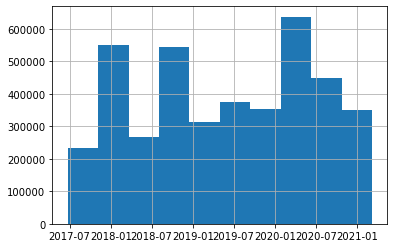

In [128]:
df['tweet_created_at'].hist()

In [144]:
times = df[['School','tweet_created_at']]

<AxesSubplot:>

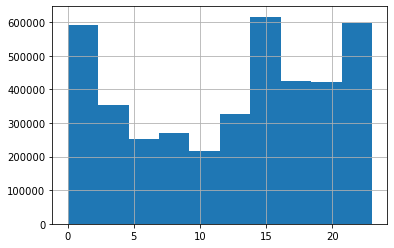

In [145]:
times['tweet_created_at'].dt.hour.hist()

In [205]:
# ALL
tweetsPerHour = times['tweet_created_at'].dt.hour.value_counts().sort_index()
tweetsPerHour

0     200930
1     196636
2     193647
3     189481
4     164810
5     138448
6     114247
7     100572
8      86537
9      84418
10     98041
11    118440
12    149892
13    175510
14    196799
15    207410
16    212230
17    211653
18    212579
19    208225
20    212814
21    201811
22    197418
23    197631
Name: tweet_created_at, dtype: int64

In [199]:
harvard = df['School']=='Harvard'
dfharvard = df[harvard]
tweetsPerHour = dfharvard['tweet_created_at'].dt.hour.value_counts().sort_index()
tweetsPerHour

0      88845
1      87876
2      89310
3      90072
4      86174
5      77762
6      68591
7      61994
8      52659
9      50102
10     55318
11     66999
12     80704
13     93212
14    102369
15    107496
16    107373
17    105839
18    104614
19     92284
20     91380
21     88603
22     90593
23     91788
Name: tweet_created_at, dtype: int64

In [201]:
yale = df['School']=='Yale'
dfyale = df[yale]
tweetsPerHour = dfyale['tweet_created_at'].dt.hour.value_counts().sort_index()
tweetsPerHour

0     23190
1     21378
2     20134
3     21583
4     18647
5     16001
6     12717
7     11483
8      9429
9      9433
10    10407
11    13061
12    16824
13    19018
14    22115
15    22181
16    22919
17    25782
18    27693
19    29394
20    27934
21    25530
22    24835
23    22627
Name: tweet_created_at, dtype: int64

In [202]:
northwestern = df['School']=='Northwestern'
dfnorthwestern = df[northwestern]
tweetsPerHour = dfnorthwestern['tweet_created_at'].dt.hour.value_counts().sort_index()
tweetsPerHour

0     67867
1     65906
2     63663
3     57635
4     43062
5     30364
6     21233
7     17348
8     15492
9     16862
10    19705
11    26165
12    36065
13    43629
14    51434
15    55326
16    59017
17    57238
18    55986
19    61781
20    70259
21    65135
22    59193
23    61277
Name: tweet_created_at, dtype: int64

In [203]:
uChicago = df['School']=='uChicago'
dfuChicago = df[uChicago]
tweetsPerHour = dfuChicago['tweet_created_at'].dt.hour.value_counts().sort_index()
tweetsPerHour

0     21028
1     21476
2     20540
3     20191
4     16927
5     14321
6     11706
7      9747
8      8957
9      8021
10    12611
11    12215
12    16299
13    19651
14    20881
15    22407
16    22921
17    22794
18    24286
19    24766
20    23241
21    22543
22    22797
23    21939
Name: tweet_created_at, dtype: int64

In [137]:
harvard = df['School']=='Harvard'
times = harvard[['School','tweet_created_at']]
tweetsPerHour = times['tweet_created_at'].dt.hour.value_counts().sort_index()

In [190]:
tweetsPerHour

0     200930
1     196636
2     193647
3     189481
4     164810
5     138448
6     114247
7     100572
8      86537
9      84418
10     98041
11    118440
12    149892
13    175510
14    196799
15    207410
16    212230
17    211653
18    212579
19    208225
20    212814
21    201811
22    197418
23    197631
Name: tweet_created_at, dtype: int64

In [143]:
tweetsPerHour

0     200930
1     196636
2     193647
3     189481
4     164810
5     138448
6     114247
7     100572
8      86537
9      84418
10     98041
11    118440
12    149892
13    175510
14    196799
15    207410
16    212230
17    211653
18    212579
19    208225
20    212814
21    201811
22    197418
23    197631
Name: tweet_created_at, dtype: int64

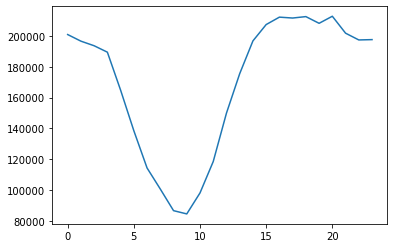

In [142]:
import matplotlib.pyplot as plt
%matplotlib inline

p = plt.plot(tweetsPerHour.index, tweetsPerHour.values)

In [185]:
# Group the data frame by month and item and extract a number of stats from each group
df.set_index('tweet_created_at_hour', inplace=True)

timingbySchool = df.groupby(['School', 'tweet_created_at_hour']).agg(
    tweets = pd.NamedAgg(column='tweet_created_at_hour', aggfunc = 'count')
)

In [189]:
timingbySchool.head(100) #TODO if time extract this and plot it in presentation

tweets
School   tweet_created_at_hour        
Harvard  0                       88845
         1                       87876
         2                       89310
         3                       90072
         4                       86174
...                                ...
uChicago 19                      24766
         20                      23241
         21                      22543
         22                      22797
         23                      21939

[96 rows x 1 columns]

## How unique are the messages for each of these universities?
 - Are they mostly unique? Or mostly people are just copy-pasting the same text?
 - You can use something like Jaccard similarity / Cosine Similarity / Simhash / Minhash to measure uniqueness / similarity
 - Visualize message duplication (for each university – not between the universities)
 - Please note: this is not a topic modeling (LDA / LSA) – but text similarity analysis.

In [273]:
df.head(1)

,user_id,friends_count,user_location,user_name,user_screen_name,user_created_at,user_created_at_date,description,favourites_count,user_followers_count,...,retweeted_count,retweet_created_at,retweet_created_at_date,retweet_lag_minutes,retweeted_status_followers_count,retweet_user_name,retweet_user_location,length_of_text,School,tweet_created_at_hour
0,\n741067300866916352,2076.0,"San Francisco, CA",Nathan Mannas,ncMannas,2016-06-10 00:39:47,2016-06-10,"Food, the arts, sports and tech. A new account, a fresh start.",12343.0,1260,...,50.0,2017-06-22 17:41:07,2017-06-22,341.0,140549.0,History in Moments,NaN,85.0,Harvard,23


In [289]:
# Creating a SparkDF of only our titles
text_df = df['text']

In [290]:
my_text = pd.DataFrame(text_df)

In [291]:
my_text.head(1)

,text
0,rt @historyinmoment: barack obama at harvard university 1988. https://t.co/dfdhezfsrh


In [292]:
# Write for safe keeping and easier starting later on
my_text.to_csv(r'text_only.csv', index = False, header = True)

In [293]:
## So I had to import it using pandas then convert it to a spark DF
%time my_new_text = pd.read_csv('text_only.csv')

Wall time: 5.7 s


In [295]:
my_new_text.head()

,text
0,rt @historyinmoment: barack obama at harvard university 1988. https://t.co/dfdhezfsrh
1,"rt @daveweasel: @realdonaldtrump i know harvard doesn't have the same reputation as trump university, but... https://t.co/rogy16r1kc"
2,"rt @daveweasel: @realdonaldtrump i know harvard doesn't have the same reputation as trump university, but... https://t.co/rogy16r1kc"
3,rt @upfrontafrica: emperor haile selassie visits #ethiopian students at harvard university in 1963 #throwbackthursday https://t.co/flwijdqj…
4,"rt @daveweasel: @realdonaldtrump i know harvard doesn't have the same reputation as trump university, but... https://t.co/rogy16r1kc"


#### Similarity analysis completed in GCS